# Sheet for processing and testing the robot data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import time
import sys
#df = pd.read_csv('/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/movementLeftFoot.csv')
#df=(df-df.std())/(df.mean())
path="/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/New_feet/raw/"
if sys.platform.startswith('win'):
    path="C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/robot/New_feet/raw/"
df = pd.read_csv(path+'carpet_d1.1_raw_L.csv')
#df=(df-df.std())/(df.mean())

print(df.keys())

torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda)
print("GPU:",torch.cuda.is_available())

Index(['time_step', 'x', 'y', 'z', 's_1_0', 's_1_1', 's_1_2', 's_1_3', 's_1_4',
       's_1_5', 's_1_6', 's_1_7', 's_1_8', 's_1_9', 's_1_10', 's_1_11',
       's_1_12', 's_1_13', 's_1_14', 's_1_15', 's_2_0', 's_2_1', 's_2_2',
       's_2_3', 's_2_4', 's_2_5', 's_2_6', 's_2_7', 's_2_8', 's_2_9', 's_2_10',
       's_2_11', 's_2_12', 's_2_13', 's_2_14', 's_2_15'],
      dtype='object')
11.7
GPU: True


### Data sorting

In [9]:
def genDataSet(var):
    X,y=sort_data("carpet_d1.1_raw_L.csv",var)
    X1,y1=sort_data("carpet_d1.1_raw_R.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("carpet_d1_raw_L.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("carpet_d1_raw_R.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("wood_d1_raw_R.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("wood_d1_raw_L.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    return X,y
def sort_data(name,vibration=True,dir="all"):
    df = pd.read_csv(path+name)
    df=pd.DataFrame(df).fillna(0)
    if vibration:
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z"]:
                ar.append(df[key])
        x=np.array(ar)
    else: #return without vibration data
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z","s_1_7","s_2_7"]:
                ar.append(df[key])
        x=np.array(ar)
    if dir=="left":
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z"] and "s_1" in key:
                ar.append(df[key])
        x=np.array(ar)
    elif dir=="right":
        ar=[]
        for key in list(df.keys()):
            if key not in ["x","y","z"] and "s_2" in key:
                ar.append(df[key])
        x=np.array(ar)
    x=x.T #transpose to have layers
    y=np.array([df['x'],df['y'],df['z']])
    y=y.T
    nan_indices = np.where(np.isnan(y))
    y[nan_indices]=0
    print("X data:",x.shape,"/ny data:",y.shape)
    return x,y

X,y=sort_data("carpet_d1.1_raw_L.csv")
X1,y1=sort_data("carpet_d1.1_raw_R.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("carpet_d1_raw_L.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("carpet_d1_raw_R.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d1_raw_R.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d1_raw_L.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

def gen_temporal_data(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,X.shape[1]*T))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.concatenate(ar,axis=0)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y

def gen_temporal_data_2(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,T,X.shape[1]))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.array(ar)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y

X_,y_=gen_temporal_data(X,y,60)
print(X_.shape,y_.shape)


X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
(25590, 1920) (25590, 3)


### Regression

In [24]:

X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
ridge_model.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred = ridge_model.predict(X_test)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.5f}")

Mean Squared Error: 0.62216


Time taken 1705231904.7500153


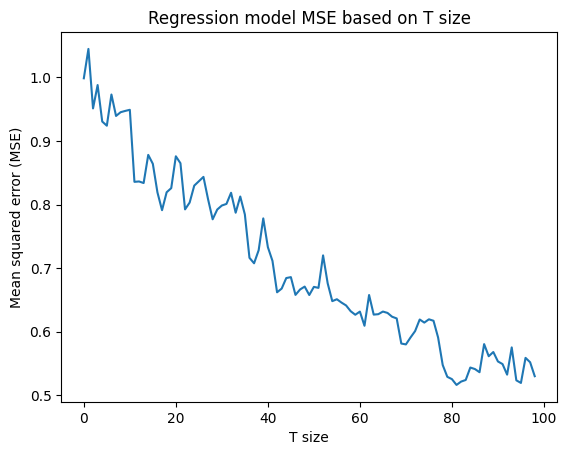

(0.6677676601926569, 1.0447369659534196, 0.5162535213781586, 0.705924776185626)

In [4]:
losses=[]
t=time.time()
for t in range(1,100):
    X_,y_=gen_temporal_data(X,y_,t)
    X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

    # Create a Ridge Regression model
    alpha = 1.0  # Ridge regularization parameter (adjust as needed)
    ridge_model = Ridge(alpha=alpha)
    #ridge_model = LinearRegression(positive=True)
    # Fit the model to the training data
    ridge_model.fit(X_train, Y_train)

    # Make predictions on the test data
    Y_pred = ridge_model.predict(X_test)

    # Calculate Mean Squared Error (MSE) to evaluate the model
    mse = mean_squared_error(Y_test, Y_pred)
    losses.append(mse)
print("Time taken",time.time()-t)
plt.plot(losses)
plt.title("Regression model MSE based on T size")
plt.ylabel("Mean squared error (MSE)")
plt.xlabel("T size")
plt.show()
np.median(losses),np.max(losses),np.min(losses),np.average(losses)

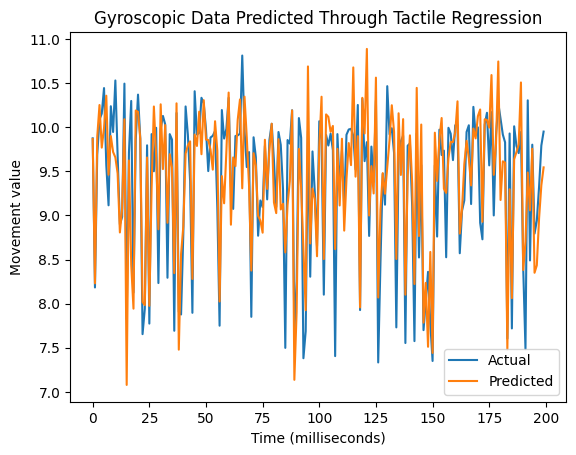

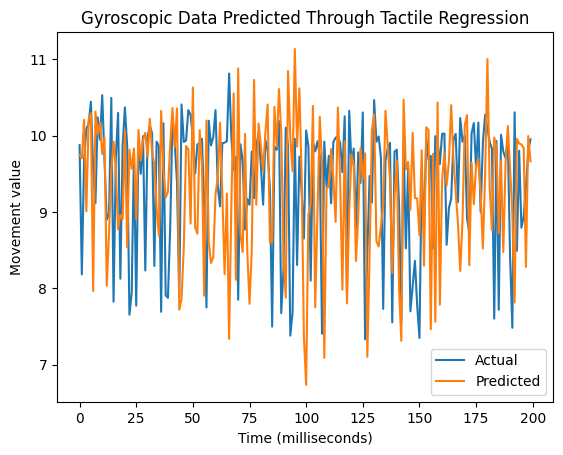

In [25]:
Y_pred = ridge_model.predict(X_train)
plt.plot(Y_train[:,0][0:200],label="Actual")
plt.plot(Y_pred[:,0][0:200],label="Predicted")

plt.title("Gyroscopic Data Predicted Through Tactile Regression")
plt.ylabel("Movement value")
plt.xlabel("Time (milliseconds)")
plt.legend(loc="lower right")
plt.show()

Y_pred = ridge_model.predict(X_test)
plt.plot(Y_train[:,0][0:200],label="Actual")
plt.plot(Y_pred[:,0][0:200],label="Predicted")

plt.title("Gyroscopic Data Predicted Through Tactile Regression")
plt.ylabel("Movement value")
plt.xlabel("Time (milliseconds)")
plt.legend(loc="lower right")
plt.show()

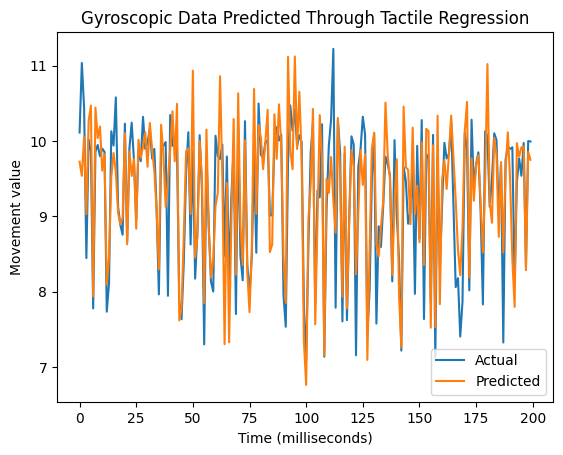

In [9]:
Y_pred = ridge_model.predict(X_test)
plt.plot(Y_test[:,0][0:200],label="Actual")
plt.plot(Y_pred[:,0][0:200],label="Predicted")


plt.title("Gyroscopic Data Predicted Through Tactile Regression")
plt.ylabel("Movement value")
plt.xlabel("Time (milliseconds)")
plt.legend(loc="lower right")
plt.show()


In [ ]:

"""
plt.plot(Y_pred[:,1][0:200],label="Predicted")
plt.plot(Y_test[:,1][0:200],label="Actual")
plt.plot(Y_pred[:,2][0:200],label="Predicted")
plt.plot(Y_test[:,2][0:200],label="Actual")
"""

#### Without vibration

In [8]:

X,y=genDataSet(False)

X data: (4950, 30) /ny data: (4950, 3)
X data: (3600, 30) /ny data: (3600, 3)
X data: (4950, 30) /ny data: (4950, 3)
X data: (3600, 30) /ny data: (3600, 3)
X data: (3600, 30) /ny data: (3600, 3)
X data: (4950, 30) /ny data: (4950, 3)


Mean Squared Error: 0.96609


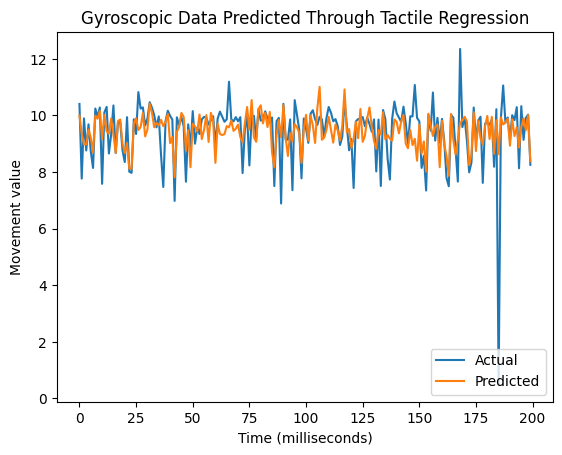

In [10]:

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
ridge_model.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred = ridge_model.predict(X_test)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.5f}")

Y_pred = ridge_model.predict(X_train)
plt.plot(Y_train[:,0][0:200],label="Actual")
plt.plot(Y_pred[:,0][0:200],label="Predicted")

plt.title("Gyroscopic Data Predicted Through Tactile Regression")
plt.ylabel("Movement value")
plt.xlabel("Time (milliseconds)")
plt.legend(loc="lower right")
plt.show()

Time taken 1705232295.720237


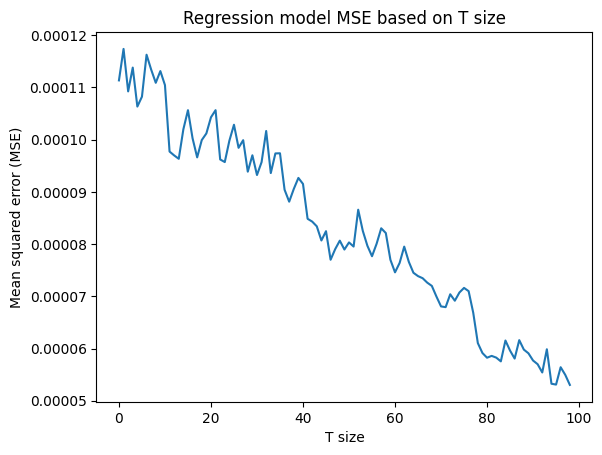

In [11]:
losses=[]
t=time.time()
for t in range(1,100):
    X_,y_=gen_temporal_data(X,y_,t)
    X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

    # Create a Ridge Regression model
    alpha = 1.0  # Ridge regularization parameter (adjust as needed)
    ridge_model = Ridge(alpha=alpha)
    #ridge_model = LinearRegression(positive=True)
    # Fit the model to the training data
    ridge_model.fit(X_train, Y_train)

    # Make predictions on the test data
    Y_pred = ridge_model.predict(X_test)

    # Calculate Mean Squared Error (MSE) to evaluate the model
    mse = mean_squared_error(Y_test, Y_pred)
    losses.append(mse/10000)
print("Time taken",time.time()-t)
plt.plot(losses)
plt.title("Regression model MSE based on T size")
plt.ylabel("Mean squared error (MSE)")
plt.xlabel("T size")
plt.show()

In [10]:
np.median(losses),np.max(losses),np.min(losses),np.average(losses)

(3.181082132055287, 4.010584362344202, 2.498352895845421, 3.264211665425633)

#### Texture study

In [10]:
X,y=genDataSet(True)
t=80
X_,y_=gen_temporal_data(X,y,t)
X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
normal_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
normal_model.fit(X_train, Y_train)
# Make predictions on the test data
Y_pred = normal_model.predict(X_test)
# Calculate Mean Squared Error (MSE) to evaluate the model
mse_norm = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse_norm :.5f}")

def getMSEData(nameLeft,nameRight,model,t=60):
    X,y=sort_data(nameLeft)
    X1,y1=sort_data(nameRight)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X,y=gen_temporal_data(X,y,t)
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)
def getMSEPreds(nameLeft,nameRight,model,t=60):
    X,y=sort_data(nameLeft)
    X1,y1=sort_data(nameRight)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X,y=gen_temporal_data(X,y,t)
    y_pred = model.predict(X)
    return(y, y_pred)

mse_texture=getMSEData("carpet_d1.1_raw_L.csv","carpet_d1.1_raw_R.csv",normal_model,t)
mse_concrete=getMSEData("carpet_d1_raw_L.csv","carpet_d1_raw_R.csv",normal_model,t)
mse_outdoor=getMSEData("carpet_d1.1_raw_L.csv","carpet_d1.1_raw_R.csv",normal_model,t)
print("****************************\n\nNormal MSE:",mse_norm,"\n\nCarpet MSE:",mse_texture,"\n\nConcrete MSE:",mse_concrete,"\n\nOutdoor MSE:",mse_outdoor)

X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
Mean Squared Error: 0.52500
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
****************************

Normal MSE: 0.5250000422824621 

Carpet MSE: 0.3443611952015624 

Concrete MSE: 0.35958894002119085 

Outdoor MSE: 0.3443611952015624


In [147]:
y,yp=getMSEPreds("accmovementLeftFoot.csv","accmovementRightFoot.csv",normal_model,t)
yt,ypt=getMSEPreds("accmovementLeftFootCarpet.csv","accmovementRightFootCarpet.csv",normal_model,t)
yc,ypc=getMSEPreds("accmovementLeftFootConrete.csv","accmovementRightFootConrete.csv",normal_model,t)
yo,ypo=getMSEPreds("accmovementLeftFootOutdoor.csv","accmovementRightFootOutdoor.csv",normal_model,t)

X data: (4444, 6) /ny data: (4444, 3)
X data: (12719, 6) /ny data: (12719, 3)
X data: (3932, 6) /ny data: (3932, 3)
X data: (10312, 6) /ny data: (10312, 3)
X data: (2624, 6) /ny data: (2624, 3)
X data: (2214, 6) /ny data: (2214, 3)
X data: (8122, 6) /ny data: (8122, 3)
X data: (5560, 6) /ny data: (5560, 3)


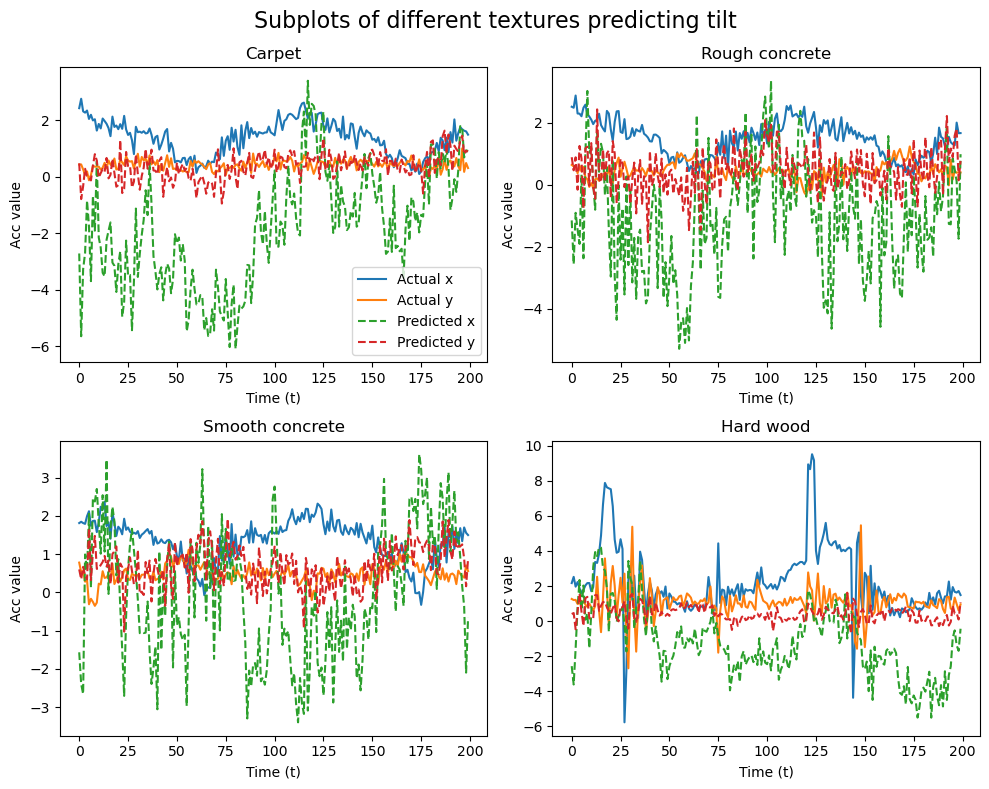

In [148]:
# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axis=[1,2]
start=100
show=300
# Plotting each set of x and y data on separate subplots
axs[0, 0].plot(yt[start:show,axis],label=["Actual x","Actual y"])
axs[0, 0].plot(ypt[start:show,axis],"--",label=["Predicted x","Predicted y"])
axs[0, 0].set_title('Carpet')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Time (t)')
axs[0, 0].set_ylabel('Acc value')

axs[0, 1].plot(yc[start:show,axis])
axs[0, 1].plot(ypc[start:show,axis],"--")
axs[0, 1].set_title('Rough concrete')
axs[0, 1].set_xlabel('Time (t)')
axs[0, 1].set_ylabel('Acc value')

axs[1, 0].plot(yo[start:show,axis])
axs[1, 0].plot(ypo[start:show,axis],"--")
axs[1, 0].set_title('Smooth concrete')
axs[1, 0].set_xlabel('Time (t)')
axs[1, 0].set_ylabel('Acc value')

axs[1, 1].plot(y[start:show,axis])
axs[1, 1].plot(yp[start:show,axis],"--")
axs[1, 1].set_title('Hard wood')
axs[1, 1].set_xlabel('Time (t)')
axs[1, 1].set_ylabel('Acc value')

# Adding a central title
plt.suptitle('Subplots of different textures predicting tilt', fontsize=16)

plt.tight_layout()

# Displaying the plots
plt.show()

##### All models


X data: (4444, 6) /ny data: (4444, 3)
X data: (12719, 6) /ny data: (12719, 3)
X data: (10312, 6) /ny data: (10312, 3)
X data: (3932, 6) /ny data: (3932, 3)
X data: (2214, 6) /ny data: (2214, 3)
X data: (2624, 6) /ny data: (2624, 3)
X data: (5560, 6) /ny data: (5560, 3)
X data: (8122, 6) /ny data: (8122, 3)
Mean Squared Error: 2.55085
X data: (4444, 6) /ny data: (4444, 3)
X data: (12719, 6) /ny data: (12719, 3)
X data: (3932, 6) /ny data: (3932, 3)
X data: (10312, 6) /ny data: (10312, 3)
X data: (2624, 6) /ny data: (2624, 3)
X data: (2214, 6) /ny data: (2214, 3)
X data: (8122, 6) /ny data: (8122, 3)
X data: (5560, 6) /ny data: (5560, 3)


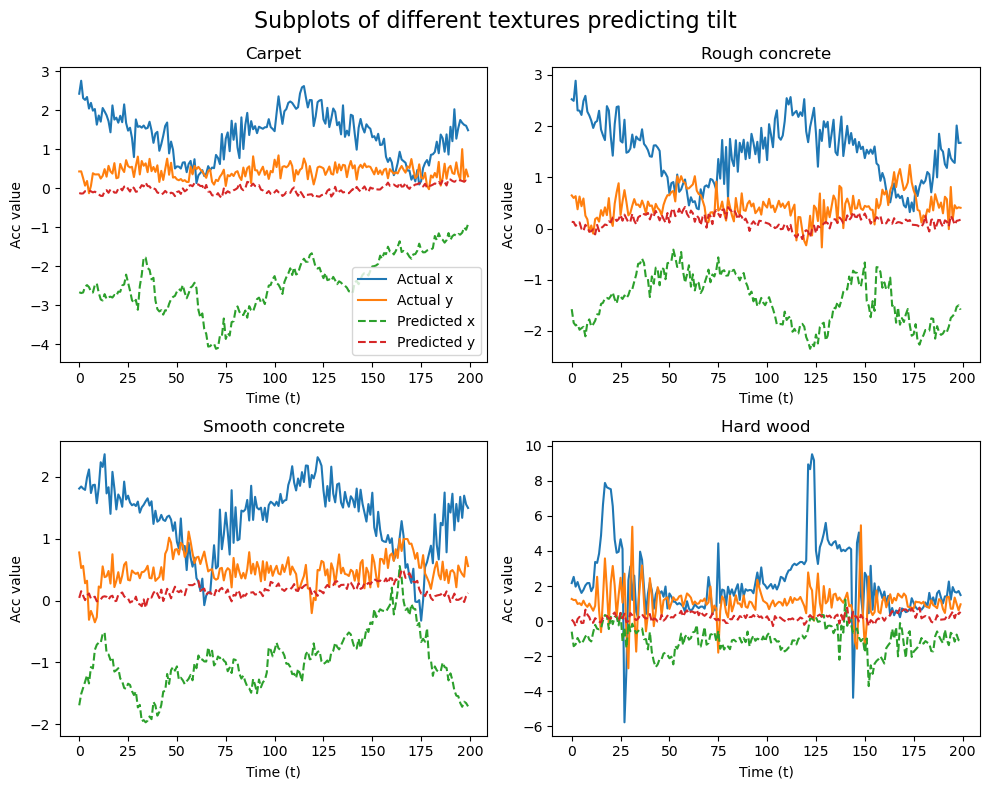

X data: (3932, 6) /ny data: (3932, 3)
X data: (10312, 6) /ny data: (10312, 3)
X data: (2624, 6) /ny data: (2624, 3)
X data: (2214, 6) /ny data: (2214, 3)
X data: (8122, 6) /ny data: (8122, 3)
X data: (5560, 6) /ny data: (5560, 3)
****************************

Normal MSE: 2.849354558738814 

Carpet MSE: 3.127998655057228 

Concrete MSE: 2.746650531018806 

Outdoor MSE: 2.5452349988522687


In [150]:
X,y=sort_data("accmovementLeftFoot.csv")
X1,y1=sort_data("accmovementRightFoot.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementRightFootCarpet.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementLeftFootCarpet.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementRightFootConrete.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementLeftFootConrete.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementRightFootOutdoor.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementLeftFootOutdoor.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

t=80
X_,y_=gen_temporal_data(X,y,t)
X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
uber_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
uber_model.fit(X_train, Y_train)
# Make predictions on the test data
Y_pred = uber_model.predict(X_test)
# Calculate Mean Squared Error (MSE) to evaluate the model
mse_norm = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.5f}")

y,yp=getMSEPreds("accmovementLeftFoot.csv","accmovementRightFoot.csv",uber_model,t)
yt,ypt=getMSEPreds("accmovementLeftFootCarpet.csv","accmovementRightFootCarpet.csv",uber_model,t)
yc,ypc=getMSEPreds("accmovementLeftFootConrete.csv","accmovementRightFootConrete.csv",uber_model,t)
yo,ypo=getMSEPreds("accmovementLeftFootOutdoor.csv","accmovementRightFootOutdoor.csv",uber_model,t)

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axis=[1,2]
start=100
show=300
# Plotting each set of x and y data on separate subplots
axs[0, 0].plot(yt[start:show,axis],label=["Actual x","Actual y"])
axs[0, 0].plot(ypt[start:show,axis],"--",label=["Predicted x","Predicted y"])
axs[0, 0].set_title('Carpet')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Time (t)')
axs[0, 0].set_ylabel('Acc value')

axs[0, 1].plot(yc[start:show,axis])
axs[0, 1].plot(ypc[start:show,axis],"--")
axs[0, 1].set_title('Rough concrete')
axs[0, 1].set_xlabel('Time (t)')
axs[0, 1].set_ylabel('Acc value')

axs[1, 0].plot(yo[start:show,axis])
axs[1, 0].plot(ypo[start:show,axis],"--")
axs[1, 0].set_title('Smooth concrete')
axs[1, 0].set_xlabel('Time (t)')
axs[1, 0].set_ylabel('Acc value')

axs[1, 1].plot(y[start:show,axis])
axs[1, 1].plot(yp[start:show,axis],"--")
axs[1, 1].set_title('Hard wood')
axs[1, 1].set_xlabel('Time (t)')
axs[1, 1].set_ylabel('Acc value')

# Adding a central title
plt.suptitle('Subplots of different textures predicting tilt', fontsize=16)

plt.tight_layout()

# Displaying the plots
plt.show()
mse_texture=getMSEData("accmovementLeftFootCarpet.csv","accmovementRightFootCarpet.csv",uber_model,t)
mse_concrete=getMSEData("accmovementLeftFootConrete.csv","accmovementRightFootConrete.csv",uber_model,t)
mse_outdoor=getMSEData("accmovementLeftFootOutdoor.csv","accmovementRightFootOutdoor.csv",uber_model,t)
print("****************************\n\nNormal MSE:",mse_norm,"\n\nCarpet MSE:",mse_texture,"\n\nConcrete MSE:",mse_concrete,"\n\nOutdoor MSE:",mse_outdoor)

##### Other classifiers

X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
(20456, 2560) (20456, 3)
Mean Squared Error: 0.12329
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)


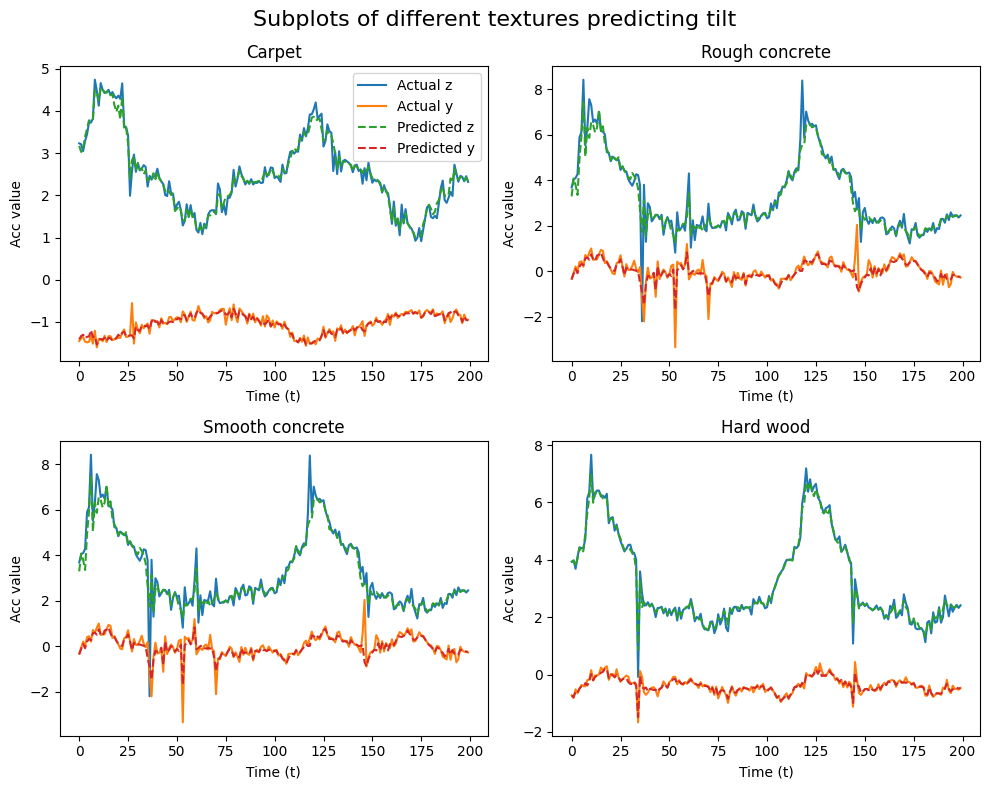

X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
****************************

Normal MSE: 0.12329060387879244 

Carpet MSE: 0.026055238738216257 

Concrete MSE: 0.07150556855282313 

Outdoor MSE: 0.026055238738216257


In [13]:
X,y=genDataSet(1)

t=80
X_,y_=gen_temporal_data(X,y,t)
X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
uber_model=RandomForestRegressor(n_estimators=50, random_state=42)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
print(X_train.shape, Y_train.shape)
uber_model.fit(X_train, Y_train)
# Make predictions on the test data
Y_pred = uber_model.predict(X_test)
# Calculate Mean Squared Error (MSE) to evaluate the model
mse_norm = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse_norm:.5f}")

#TODO get actual datasets
y,yp=getMSEPreds("carpet_d1_raw_L.csv","carpet_d1_raw_R.csv",uber_model,t) #normal
yt,ypt=getMSEPreds("carpet_d1.1_raw_L.csv","carpet_d1.1_raw_R.csv",uber_model,t) #carpet
yc,ypc=getMSEPreds("wood_d1_raw_L.csv","wood_d1_raw_R.csv",uber_model,t) #concrete
yo,ypo=getMSEPreds("wood_d1_raw_L.csv","wood_d1_raw_R.csv",uber_model,t) #outdoor


# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axis=[1,2]
start=100
show=300
# Plotting each set of x and y data on separate subplots
axs[0, 0].plot(yt[start:show,axis],label=["Actual z","Actual y"])
axs[0, 0].plot(ypt[start:show,axis],"--",label=["Predicted z","Predicted y"])
axs[0, 0].set_title('Carpet')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Time (t)')
axs[0, 0].set_ylabel('Acc value')

axs[0, 1].plot(yc[start:show,axis])
axs[0, 1].plot(ypc[start:show,axis],"--")
axs[0, 1].set_title('Rough concrete')
axs[0, 1].set_xlabel('Time (t)')
axs[0, 1].set_ylabel('Acc value')

axs[1, 0].plot(yo[start:show,axis])
axs[1, 0].plot(ypo[start:show,axis],"--")
axs[1, 0].set_title('Smooth concrete')
axs[1, 0].set_xlabel('Time (t)')
axs[1, 0].set_ylabel('Acc value')

axs[1, 1].plot(y[start:show,axis])
axs[1, 1].plot(yp[start:show,axis],"--")
axs[1, 1].set_title('Hard wood')
axs[1, 1].set_xlabel('Time (t)')
axs[1, 1].set_ylabel('Acc value')

# Adding a central title
plt.suptitle('Subplots of different textures predicting tilt', fontsize=16)

plt.tight_layout()

# Displaying the plots
plt.show()
mse_texture=getMSEData("carpet_d1.1_raw_L.csv","carpet_d1.1_raw_R.csv",uber_model,t)
mse_concrete=getMSEData("wood_d1_raw_L.csv","wood_d1_raw_R.csv",uber_model,t)
mse_outdoor=getMSEData("carpet_d1.1_raw_L.csv","carpet_d1.1_raw_R.csv",uber_model,t)
print("****************************\n\nNormal MSE:",mse_norm,"\n\nCarpet MSE:",mse_texture,"\n\nConcrete MSE:",mse_concrete,"\n\nOutdoor MSE:",mse_outdoor)

[]

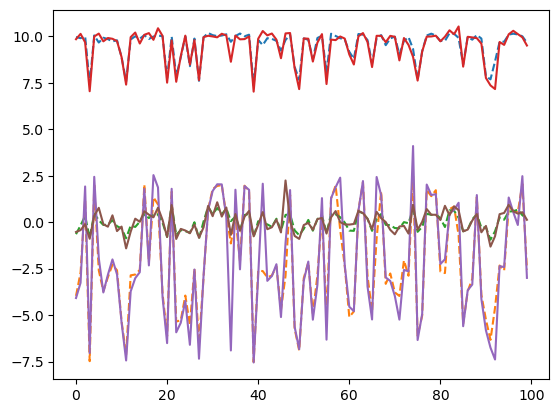

In [178]:
Y_pred = uber_model.predict(X_test)
plt.plot(Y_pred[:100,],"--")
plt.plot(Y_test[:100,])
plt.plot()

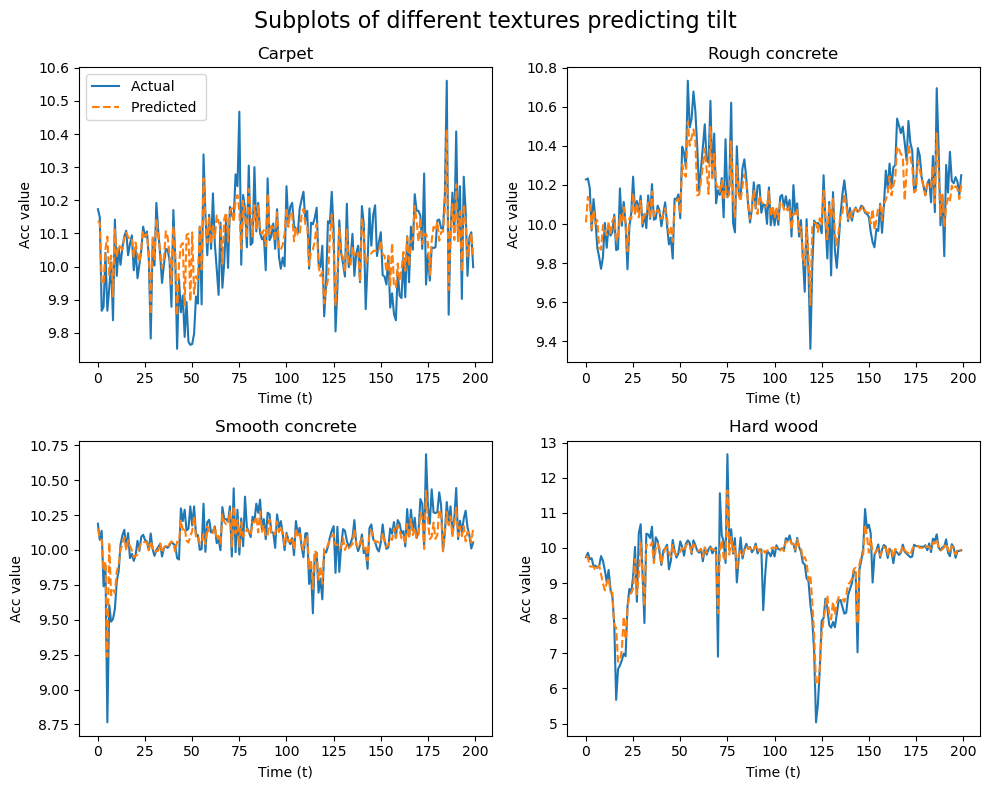

In [159]:
# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axis=0
start=100
show=300
# Plotting each set of x and y data on separate subplots
axs[0, 0].plot(yt[start:show,axis],label="Actual ")
axs[0, 0].plot(ypt[start:show,axis],"--",label="Predicted ")
axs[0, 0].set_title('Carpet')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Time (t)')
axs[0, 0].set_ylabel('Acc value')

axs[0, 1].plot(yc[start:show,axis])
axs[0, 1].plot(ypc[start:show,axis],"--")
axs[0, 1].set_title('Rough concrete')
axs[0, 1].set_xlabel('Time (t)')
axs[0, 1].set_ylabel('Acc value')

axs[1, 0].plot(yo[start:show,axis])
axs[1, 0].plot(ypo[start:show,axis],"--")
axs[1, 0].set_title('Smooth concrete')
axs[1, 0].set_xlabel('Time (t)')
axs[1, 0].set_ylabel('Acc value')

axs[1, 1].plot(y[start:show,axis])
axs[1, 1].plot(yp[start:show,axis],"--")
axs[1, 1].set_title('Hard wood')
axs[1, 1].set_xlabel('Time (t)')
axs[1, 1].set_ylabel('Acc value')

# Adding a central title
plt.suptitle('Subplots of different textures predicting tilt', fontsize=16)

plt.tight_layout()

# Displaying the plots
plt.show()

(39877, 480) (39877, 3)
X data: (4444, 6) /ny data: (4444, 3)
X data: (12719, 6) /ny data: (12719, 3)
X data: (3932, 6) /ny data: (3932, 3)
X data: (10312, 6) /ny data: (10312, 3)
X data: (2624, 6) /ny data: (2624, 3)
X data: (2214, 6) /ny data: (2214, 3)
X data: (8122, 6) /ny data: (8122, 3)
X data: (5560, 6) /ny data: (5560, 3)
1 [0.3292456835254161, 0.6343712418909079, 0.4384770048499067, 0.1868885830006551]
(39877, 480) (39877, 3)
X data: (4444, 6) /ny data: (4444, 3)
X data: (12719, 6) /ny data: (12719, 3)
X data: (3932, 6) /ny data: (3932, 3)
X data: (10312, 6) /ny data: (10312, 3)
X data: (2624, 6) /ny data: (2624, 3)
X data: (2214, 6) /ny data: (2214, 3)
X data: (8122, 6) /ny data: (8122, 3)
X data: (5560, 6) /ny data: (5560, 3)
2 [0.2076077183252666, 0.39571619598646035, 0.2392073772680553, 0.11657257034487123]
(39877, 480) (39877, 3)
X data: (4444, 6) /ny data: (4444, 3)
X data: (12719, 6) /ny data: (12719, 3)
X data: (3932, 6) /ny data: (3932, 3)
X data: (10312, 6) /ny data:

[]

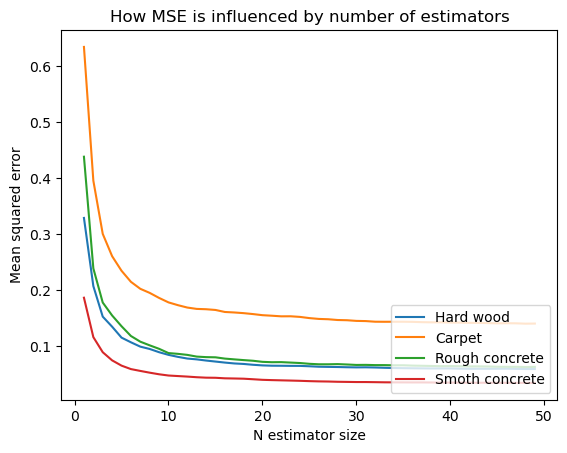

In [163]:
mse=[]
for i in range(1,50):

    test_model=RandomForestRegressor(n_estimators=i, random_state=42)
    #ridge_model = LinearRegression(positive=True)
    # Fit the model to the training data
    print(X_train.shape, Y_train.shape)
    test_model.fit(X_train, Y_train)
    # Make predictions on the test data
    Y_pred = test_model.predict(X_test)
    y=getMSEData("accmovementLeftFoot.csv","accmovementRightFoot.csv",test_model,t)
    yt=getMSEData("accmovementLeftFootCarpet.csv","accmovementRightFootCarpet.csv",test_model,t)
    yc=getMSEData("accmovementLeftFootConrete.csv","accmovementRightFootConrete.csv",test_model,t)
    yo=getMSEData("accmovementLeftFootOutdoor.csv","accmovementRightFootOutdoor.csv",test_model,t)
    mse.append([y,yt,yc,yo])
    print(i,mse[-1])

mse=np.array(mse)
x=[i for i in range(1,50)]
plt.plot(x,mse[:,0],label="Hard wood")
plt.plot(x,mse[:,1],label="Carpet")
plt.plot(x,mse[:,2],label="Rough concrete")
plt.plot(x,mse[:,3],label="Smoth concrete")
plt.title("How MSE is influenced by number of estimators")
plt.ylabel("Mean squared error")
plt.xlabel("N estimator size")
plt.legend(loc="lower right")
plt.plot()

### LSTM

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagation
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


#### Prep data

In [28]:
#prep data
def getData(X,y,T):
    X_,y_=gen_temporal_data_2(X,y,T)
    #reduction
    #X_=(X_-np.average(X_))/np.std(X_)
    #y=(y-np.average(y))/np.std(y)
    #split
    X_train, X_test, Y_train, Y_test = train_test_split(X_.astype(np.float32)[0:100], y_.astype(np.float32)[0:100], test_size=0.2, random_state=42)
    X_train=torch.tensor(X_train).to(device)
    X_test=torch.tensor(X_test).to(device)
    Y_train=torch.tensor(Y_train).to(device)
    Y_test=torch.tensor(Y_test).to(device)
    return X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test=getData(X,y,50)

In [29]:
# Example usage:
input_size = 32
hidden_size = 64
num_layers = 2
output_size = 3

lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

n = 10
input_data = X_train[0:n]
print(input_data.shape,input_data.dtype)
output = lstm_model(input_data)
print("LSTM Output:", output)

torch.Size([10, 50, 32]) torch.float32
LSTM Output: tensor([[ 0.0477,  0.0605,  0.0641],
        [-0.0929,  0.0815, -0.2268],
        [ 0.0201,  0.1135, -0.0818],
        [ 0.0225,  0.1264, -0.0626],
        [-0.0006,  0.1151, -0.2103],
        [-0.0018,  0.0925, -0.1475],
        [ 0.0315,  0.1213, -0.0603],
        [-0.1036,  0.0754, -0.2220],
        [ 0.0242,  0.0974, -0.1645],
        [-0.0204,  0.1216, -0.2261]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


#### Training

In [32]:
def train(X_train,Y_train,X_test,Y_test,num_epochs = 100,learning_rate = 0.01):
    # Split your dataset into training and validation sets
    # train_data, val_data = ...
    lstm_model=LSTMModel(X_train.shape[2],64,2,Y_train.shape[1]).to(device)
    # Create data loaders for training and validation

    # Initialize the optimizer
    optimizer = optim.SGD(lstm_model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    history_train=[]
    history_test=[]
    # Training loop
    for epoch in range(num_epochs):
        lstm_model.train()

        optimizer.zero_grad()
        # Forward pass
        outputs = lstm_model(X_train)

        # Calculate the loss
        loss = criterion(outputs, Y_train)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss = loss.item()
        history_train.append(total_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

        # Validation
        lstm_model.eval()
        with torch.no_grad():
            total_val_loss = 0

            outputs = lstm_model(X_test)
            val_loss = criterion(outputs, Y_test)
            total_val_loss = val_loss.item()

            print(f"Validation Loss: {total_val_loss:.4f}")
            history_test.append(total_val_loss)
    # Save the trained model
    #torch.save(lstm_model.state_dict(), "lstm_model.pth")
    return history_train, history_test

lossTrain,lossTest=train(X_train,Y_train,X_test,Y_test,num_epochs = 10000,learning_rate = 0.01)

Epoch [1/10000], Loss: 34.1452
Validation Loss: 32.8730
Epoch [2/10000], Loss: 32.9957
Validation Loss: 31.6703
Epoch [3/10000], Loss: 31.7793
Validation Loss: 30.4622
Epoch [4/10000], Loss: 30.5579
Validation Loss: 29.2259
Epoch [5/10000], Loss: 29.3082
Validation Loss: 27.9442
Epoch [6/10000], Loss: 28.0127
Validation Loss: 26.6054
Epoch [7/10000], Loss: 26.6588
Validation Loss: 25.2022
Epoch [8/10000], Loss: 25.2389
Validation Loss: 23.7325
Epoch [9/10000], Loss: 23.7501
Validation Loss: 22.1985
Epoch [10/10000], Loss: 22.1943
Validation Loss: 20.6072
Epoch [11/10000], Loss: 20.5781
Validation Loss: 18.9704
Epoch [12/10000], Loss: 18.9130
Validation Loss: 17.3042
Epoch [13/10000], Loss: 17.2150
Validation Loss: 15.6289
Epoch [14/10000], Loss: 15.5045
Validation Loss: 13.9683
Epoch [15/10000], Loss: 13.8054
Validation Loss: 12.3483
Epoch [16/10000], Loss: 12.1442
Validation Loss: 10.7962
Epoch [17/10000], Loss: 10.5474
Validation Loss: 9.3387
Epoch [18/10000], Loss: 9.0448
Validation

#### Opening data

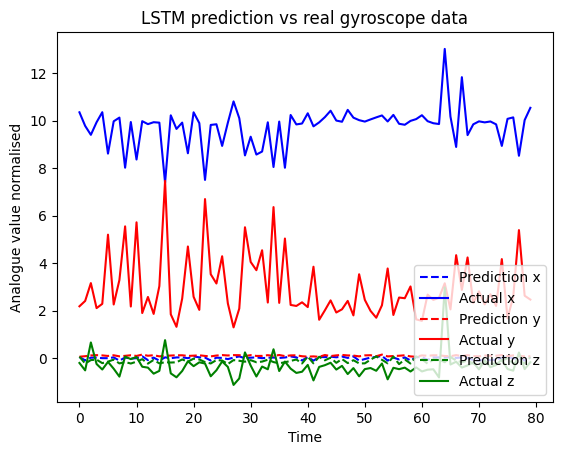

4.333886

In [34]:
X_train, X_test, Y_train, Y_test=getData(X,y,50)
#lstm_model=LSTMModel(X_train.shape[2],50,2,Y_train.shape[1]).to(device)
#lstm_model.load_state_dict(torch.load(path+"GPUCluster/data/lstm_model.pth",map_location=torch.device('cpu')))
outputs = lstm_model(X_train)

plt.plot(outputs[:,0].cpu().detach().numpy(),"--",c="b",label="Prediction x")
plt.plot(Y_train[:,0].cpu().detach().numpy(),c="b",label="Actual x")

plt.plot(outputs[:,1].cpu().detach().numpy(),"--",c="r",label="Prediction y")
plt.plot(Y_train[:,1].cpu().detach().numpy(),c="r",label="Actual y")

plt.plot(outputs[:,2].cpu().detach().numpy(),"--",c="g",label="Prediction z")
plt.plot(Y_train[:,2].cpu().detach().numpy(),c="g",label="Actual z")
plt.xlabel("Time")
plt.ylabel("Analogue value normalised")
plt.title("LSTM prediction vs real gyroscope data")
plt.legend(loc="lower right")
plt.show()
np.average(np.abs(outputs.cpu().detach().numpy()-Y_train.cpu().detach().numpy()))

[2.9940157, 2.9824908, 2.965934, 2.9483712, 2.9346056, 2.9294667, 2.9319146, 2.9334247, 2.933404, 2.9260583, 2.918158, 2.9097064, 2.8919957, 2.875303, 2.8559835, 2.854029, 2.8592684, 2.8687835, 2.8707442, 2.8689225, 2.868931, 2.871277, 2.8762708, 2.8775403, 2.879662, 2.8792796, 2.8790755, 2.876801, 2.8779988]


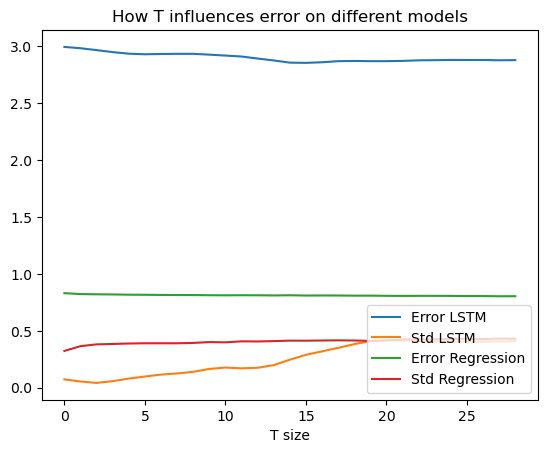

In [51]:
ar=[]
std=[]
ar1=[]
std1=[]
for i in range(1,30):
    X_train, X_test, Y_train, Y_test=getData(X,y,i)
    outputs = lstm_model(X_train)
    ar.append(np.average(np.abs(outputs.detach().numpy()-Y_train.detach().numpy())))
    std.append(np.std(outputs.detach().numpy()))
    
    X_,y_=gen_temporal_data(X,y,i)
    y_=y_[:,2]
    X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

    # Create a Ridge Regression model
    alpha = 1.0  # Ridge regularization parameter (adjust as needed)
    ridge_model = Ridge(alpha=alpha)
    #ridge_model = LinearRegression(positive=True)
    # Fit the model to the training data
    ridge_model.fit(X_train, Y_train)

    # Make predictions on the test data
    Y_pred = ridge_model.predict(X_train)

    ar1.append(np.average(np.abs(Y_pred-Y_train)))
    std1.append(np.std(Y_pred))

print(ar)
plt.plot(ar,label="Error LSTM")
plt.plot(std,label="Std LSTM")
plt.plot(ar1,label="Error Regression")
plt.plot(std1,label="Std Regression")
plt.title("How T influences error on different models")
plt.xlabel("T size")
plt.legend(loc="lower right")
plt.show()

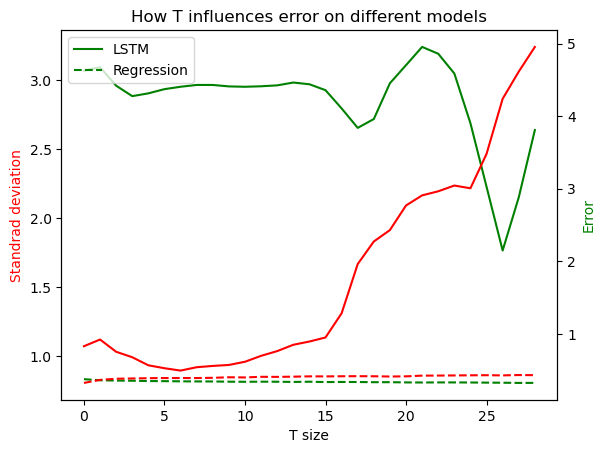

In [49]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(ar,c="g",label="LSTM")
ax2.plot(std,c="r",label="Std LSTM")
ax1.plot(ar1,"--",c="g",label="Regression")
ax2.plot(std1,"--",c="r",label="Std Regression")

ax1.set_xlabel('T size')
ax1.set_ylabel('Standrad deviation', color='r')
ax2.set_ylabel('Error', color='g')
ax1.set_title("How T influences error on different models")

ax1.legend(loc="upper left")

### Visualisation 

/tmp/ipykernel_30344/3896005188.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # You can choose different colormaps


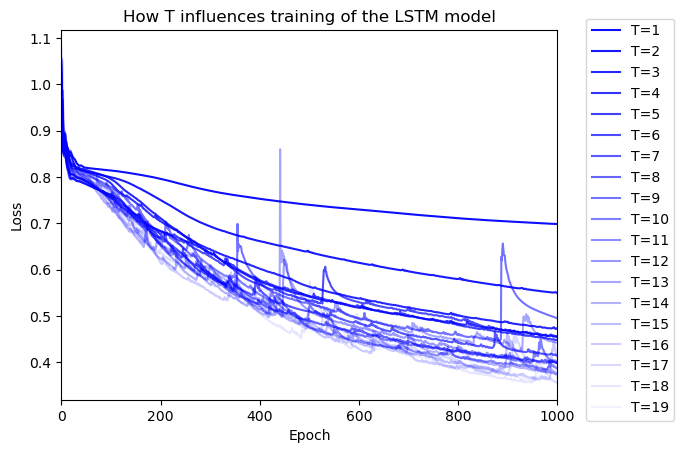

In [37]:
from matplotlib.cm import get_cmap
cmap = get_cmap('tab20')  # You can choose different colormaps

filename="train_loss_t="

typ=".npy"
for i in range(1,20):
    shade=i/20
    data=np.load("/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/GPUCluster/data/"+filename+str(i)+"_"+typ)
    plt.plot(data,label="T="+str(i),color="b",alpha=1 - shade)

plt.title("How T influences training of the LSTM model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right",bbox_to_anchor=(1.25, 1.05))
plt.xlim([0,1000])
plt.show()

X data: (4444, 3) /ny data: (4444, 3)
X data: (12719, 3) /ny data: (12719, 3)


/tmp/ipykernel_4303/2142451300.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap='Blues'), label='Left foot pressures')
/tmp/ipykernel_4303/2142451300.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap='Greens'), label='Right foot pressures')


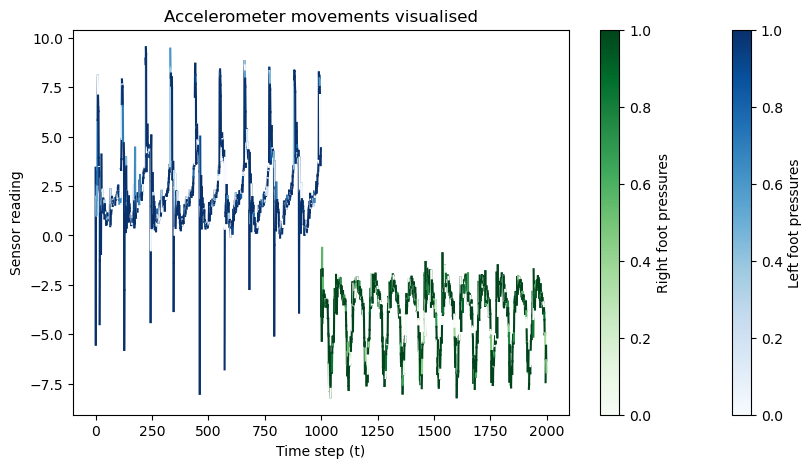

In [71]:
X,y=sort_data("accmovementLeftFoot.csv",dir="left")
#X1,y1=sort_data("movementLeftFoot1.csv")
#X=np.concatenate((X,X1),axis=0)
#y=np.concatenate((y,y1),axis=0)
axis=1
maxsize=1000
colors = np.max(X[0:maxsize],axis=1)
plt.figure(figsize=(10, 5))  # Width: 10 units, Height: 5 units

xx=[i for i in range(maxsize)]
for i in range(len(xx) - 1):
    plt.plot(xx[i:i+2], y[i:i+2,axis], color=plt.cm.Blues(colors[i]))

X1,y1=sort_data("accmovementRightFoot.csv",dir="right")
colors = np.max(X1[0:maxsize],axis=1)
xx=[i for i in range(maxsize,maxsize+maxsize)]
for i in range(len(xx) - 1):
    plt.plot(xx[i:i+2], y1[i:i+2,axis], color=plt.cm.Greens(colors[i]))

plt.title("Accelerometer movements visualised")
plt.xlabel("Time step (t)")
plt.colorbar(plt.cm.ScalarMappable(cmap='Blues'), label='Left foot pressures')
plt.colorbar(plt.cm.ScalarMappable(cmap='Greens'), label='Right foot pressures')
plt.ylabel("Sensor reading")
plt.show()

In [60]:
dir(plt.cm)

['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'ColormapRegistry',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'Mapping',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'ScalarMappable',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 '_LUTSIZE',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',

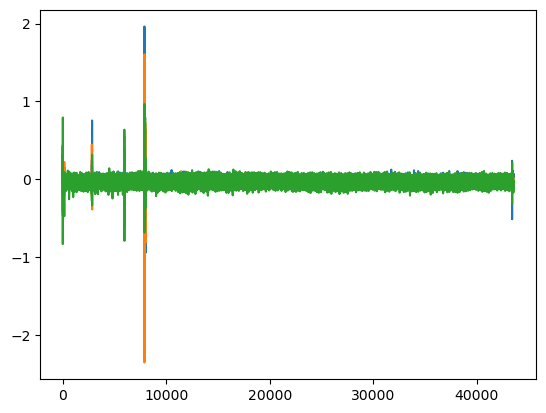

In [3]:
plt.plot(df['x'][FROM:TO])
plt.plot(df['y'][FROM:TO])
plt.plot(df['z'][FROM:TO])
plt.show()

## Checking whether day affects the data

In [10]:
X,y=sort_data("accmovementLeftFootCarpetDay2.csv")
#X1,y1=sort_data("movementLeftFoot1.csv")
#X=np.concatenate((X,X1),axis=0)
#y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementRightFootCarpetDay2.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

X_,y_=gen_temporal_data(X,y,80) #replace t with whatever the model is trained on
print(X_.shape,y_.shape)
t=80
X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
Y_pred = uber_model.predict(X_test)
# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print("MSE:",mse)

X data: (5187, 6) /ny data: (5187, 3)
X data: (9433, 6) /ny data: (9433, 3)
(14540, 480) (14540, 3)
MSE: 0.30946100014928657


In [12]:
X,y=sort_data("accmovementLeftFootCarpetDay3.csv")
#X1,y1=sort_data("movementLeftFoot1.csv")
#X=np.concatenate((X,X1),axis=0)
#y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementRightFootCarpetDay3.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

X_,y_=gen_temporal_data(X,y,80) #replace t with whatever the model is trained on
print(X_.shape,y_.shape)
t=80
X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
Y_pred = uber_model.predict(X_test)
# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print("MSE:",mse)

X data: (25122, 6) /ny data: (25122, 3)
X data: (10173, 6) /ny data: (10173, 3)
(35215, 480) (35215, 3)
MSE: 1.6453240608029684


X data: (5187, 6) /ny data: (5187, 3)
X data: (9433, 6) /ny data: (9433, 3)
X data: (6838, 6) /ny data: (6838, 3)
X data: (5917, 6) /ny data: (5917, 3)


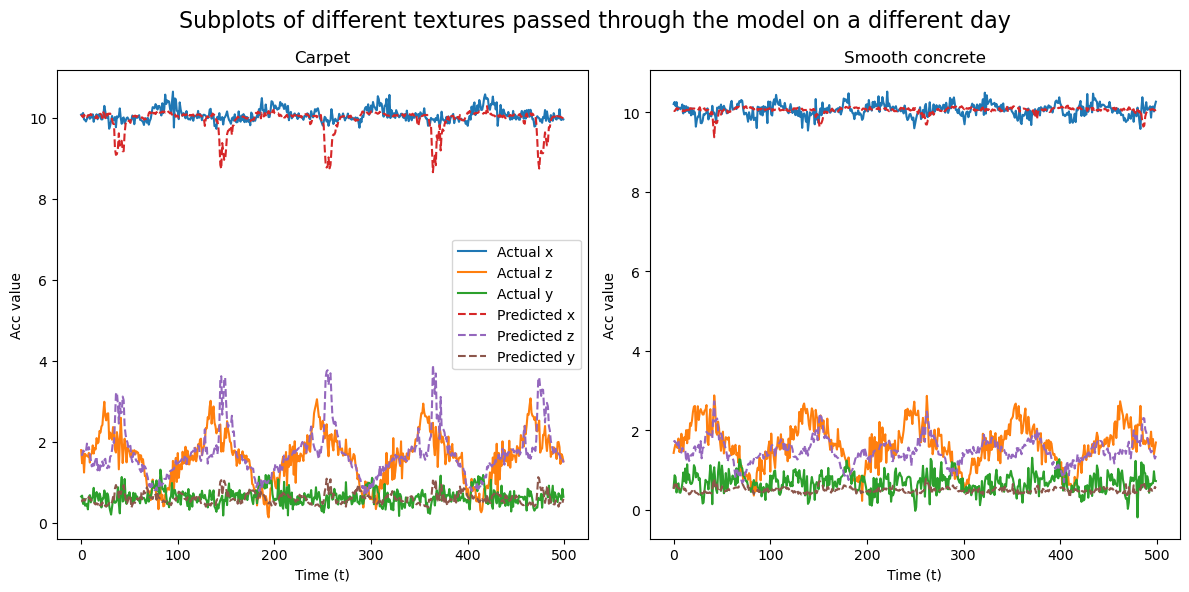

In [183]:
y,yp=getMSEPreds("accmovementLeftFootCarpetDay2.csv","accmovementRightFootCarpetDay2.csv",uber_model,t)

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axis=[0,1,2]
start=300
show=800
# Plotting each set of x and y data on separate subplots
axs[0].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[0].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[0].set_title('Carpet')
axs[0].legend()
axs[0].set_xlabel('Time (t)')
axs[0].set_ylabel('Acc value')

y,yp=getMSEPreds("accmovementLeftFootOutdoorDay2.csv","accmovementRightFootOutdoorDay2.csv",uber_model,t)
axs[1].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[1].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[1].set_title('Smooth concrete')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('Acc value')

plt.suptitle('Subplots of different textures passed through the model on a different day', fontsize=16)

plt.tight_layout()
plt.show()


X data: (3932, 6) /ny data: (3932, 3)
X data: (10312, 6) /ny data: (10312, 3)
X data: (8122, 6) /ny data: (8122, 3)
X data: (5560, 6) /ny data: (5560, 3)


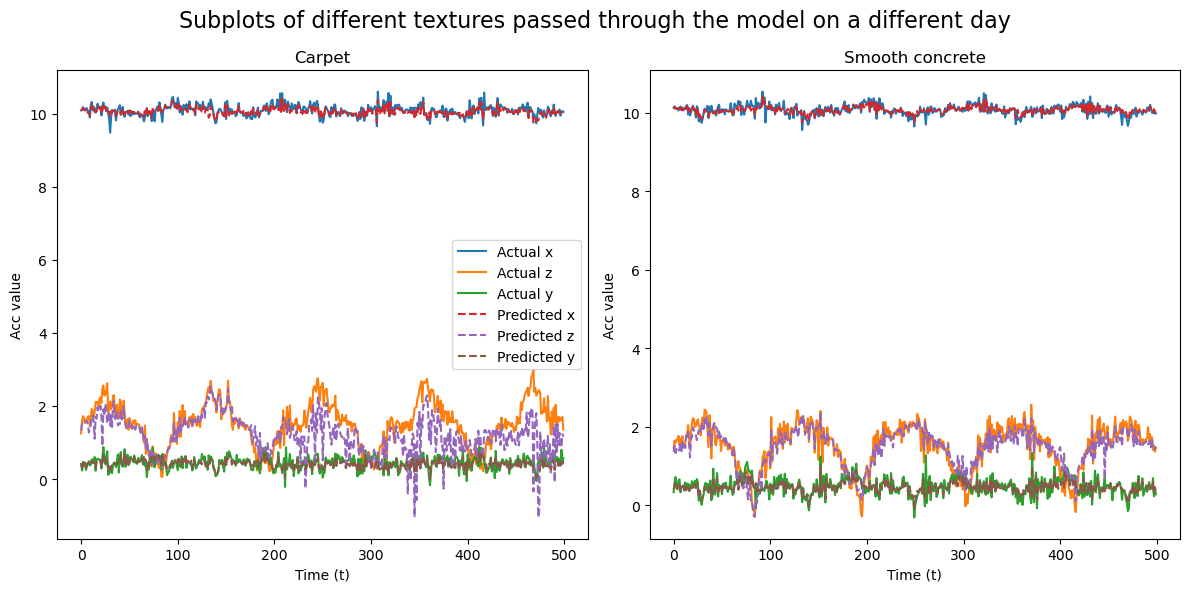

In [184]:
y,yp=getMSEPreds("accmovementLeftFootCarpet.csv","accmovementRightFootCarpet.csv",uber_model,t)

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axis=[0,1,2]
start=300
show=800
# Plotting each set of x and y data on separate subplots
axs[0].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[0].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[0].set_title('Carpet')
axs[0].legend()
axs[0].set_xlabel('Time (t)')
axs[0].set_ylabel('Acc value')

y,yp=getMSEPreds("accmovementLeftFootOutdoor.csv","accmovementRightFootOutdoor.csv",uber_model,t)
axs[1].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[1].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[1].set_title('Smooth concrete')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('Acc value')

plt.suptitle('Subplots of different textures passed through the model on a different day', fontsize=16)

plt.tight_layout()
plt.show()


X data: (3932, 6) /ny data: (3932, 3)
X data: (10312, 6) /ny data: (10312, 3)
X data: (5187, 6) /ny data: (5187, 3)
X data: (9433, 6) /ny data: (9433, 3)
X data: (25122, 6) /ny data: (25122, 3)
X data: (10173, 6) /ny data: (10173, 3)
X data: (27643, 6) /ny data: (27643, 3)
X data: (10757, 6) /ny data: (10757, 3)


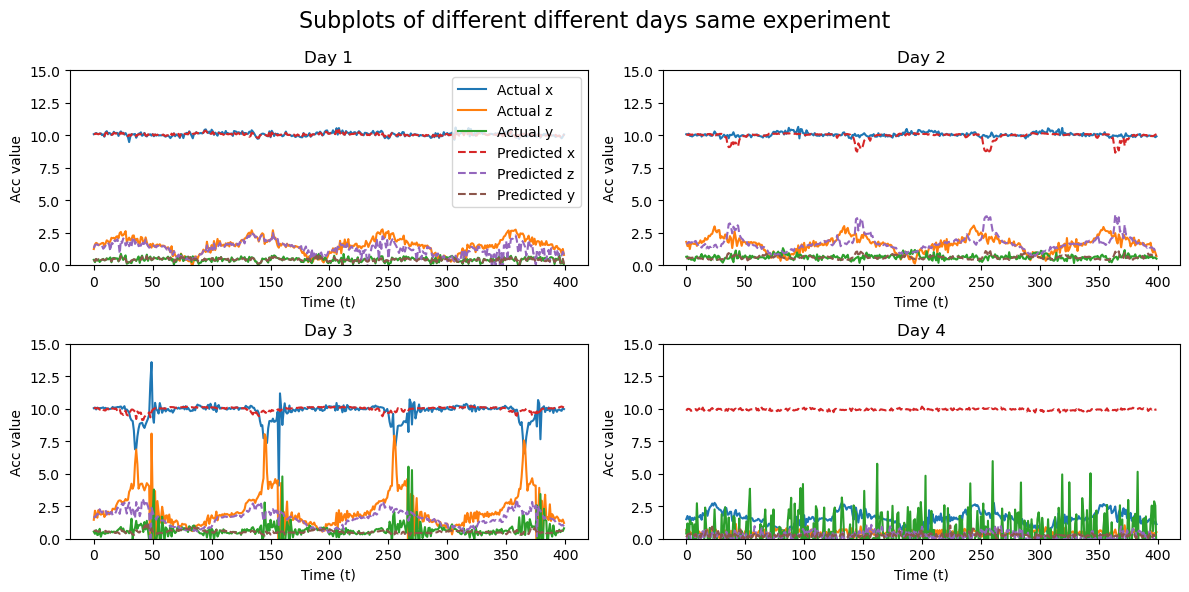

In [24]:
y,yp=getMSEPreds("accmovementLeftFootCarpet.csv","accmovementRightFootCarpet.csv",uber_model,t)

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axis=[0,1,2]
start=300
show=700
# Plotting each set of x and y data on separate subplots
axs[0,0].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[0,0].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[0,0].set_title('Day 1')
axs[0,0].legend()
axs[0,0].set_ylim([0,15])
axs[0,0].set_xlabel('Time (t)')
axs[0,0].set_ylabel('Acc value')

y,yp=getMSEPreds("accmovementLeftFootCarpetDay2.csv","accmovementRightFootCarpetDay2.csv",uber_model,t)

axs[0,1].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[0,1].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[0,1].set_title('Day 2')
axs[0,1].set_ylim([0,15])
axs[0,1].set_xlabel('Time (t)')
axs[0,1].set_ylabel('Acc value')

y,yp=getMSEPreds("accmovementLeftFootCarpetDay3.csv","accmovementRightFootCarpetDay3.csv",uber_model,t)

axs[1,0].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[1,0].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[1,0].set_title('Day 3')
axs[1,0].set_ylim([0,15])
axs[1,0].set_xlabel('Time (t)')
axs[1,0].set_ylabel('Acc value')

y,yp=getMSEPreds("accmovementLeftFootCarpetDay4.csv","accmovementRightFootCarpetDay4.csv",uber_model,t)

axs[1,1].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[1,1].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[1,1].set_title('Day 4')
axs[1,1].set_ylim([0,15])
axs[1,1].set_xlabel('Time (t)')
axs[1,1].set_ylabel('Acc value')

plt.suptitle('Subplots of different different days same experiment', fontsize=16)

plt.tight_layout()
plt.show()


## Foot visualisation 

X data: (4950, 32) /ny data: (4950, 3)
0.06060606060606061 %
0.12121212121212122 %
0.18181818181818182 %
0.24242424242424243 %
0.30303030303030304 %
0.36363636363636365 %
0.4242424242424243 %
0.48484848484848486 %
0.5454545454545455 %
0.6060606060606061 %
0.6666666666666667 %
0.7272727272727273 %
0.787878787878788 %
0.8484848484848486 %
0.9090909090909091 %
0.9696969696969697 %
1.0303030303030303 %
1.090909090909091 %
1.1515151515151514 %
1.2121212121212122 %
1.2727272727272727 %
1.3333333333333335 %
1.3939393939393938 %
1.4545454545454546 %
1.5151515151515151 %
1.575757575757576 %
1.6363636363636365 %
1.6969696969696972 %
1.7575757575757573 %
1.8181818181818181 %
1.8787878787878787 %
1.9393939393939394 %
2.0 %
2.0606060606060606 %
2.1212121212121215 %
2.181818181818182 %
2.242424242424242 %
2.3030303030303028 %
2.3636363636363638 %
2.4242424242424243 %
2.484848484848485 %
2.5454545454545454 %
2.6060606060606064 %
2.666666666666667 %
2.727272727272727 %
2.7878787878787876 %
2.848484848

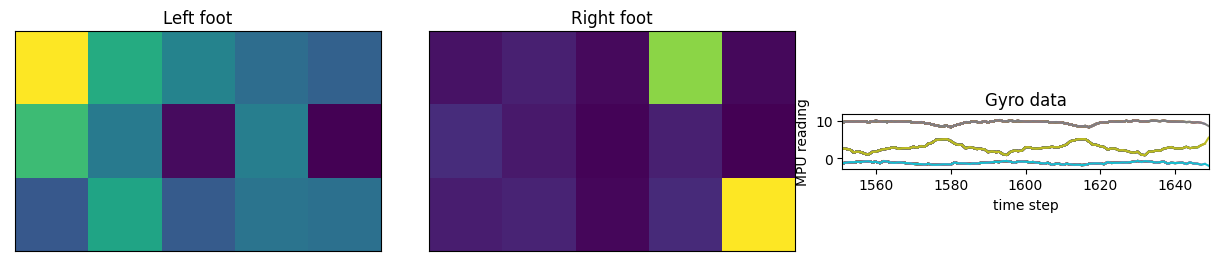

In [14]:
import cv2

def get_foot_image(processed): #get the image of an array
    grid=np.zeros((3,5))
    grid[2][4]=processed[0]
    grid[2][3]=processed[1]
    grid[2][2]=processed[2]
    grid[2][1]=processed[3]
    grid[2][0]=processed[4]

    grid[1][3]=processed[8]
    grid[1][2]=processed[9]
    grid[1][1]=processed[6]
    grid[1][0]=processed[5]

    grid[0][4]=processed[10]
    grid[0][3]=processed[11]
    grid[0][2]=processed[12]
    grid[0][1]=processed[13]
    grid[0][0]=processed[14]
    grid=(grid-np.min(grid))/(np.max(grid)-np.min(grid))
    return grid

def genVideo(filename,pathtosave):
    #open file
    x,y=sort_data(filename,vibration=True,dir="all") #loop through file name
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    data=[]
    vid_not_started=True
    out=None
    pointer=0
    for _,i in enumerate(range(0,len(x),3)): #len(x)
        ft1=get_foot_image(x[i][:16])
        ft2=get_foot_image(x[i][16:])
        #plot image
        axs[0].imshow(ft1)
        axs[0].set_title("Left foot")
        axs[0].xaxis.set_visible(False)
        axs[0].yaxis.set_visible(False)

        axs[1].imshow(ft2)
        axs[1].set_title("Right foot")
        axs[1].xaxis.set_visible(False)
        axs[1].yaxis.set_visible(False)
        #plot data
        data.append(y[i])
        #print(np.arange(pointer,i+1).shape,np.array(data)[:,0].shape)
        assert len(np.arange(pointer,_+1))<=100, "incrorrect range size: "+str(_)+","+str(pointer)
        ar=np.array(data)
        axs[2].plot(np.arange(pointer,_+1),ar[:,0])
        axs[2].plot(np.arange(pointer,_+1),ar[:,1])
        axs[2].plot(np.arange(pointer,_+1),ar[:,2])
        axs[2].set_xlabel("time step")
        axs[2].set_ylabel("MPU reading")
        axs[2].set_title("Gyro data")
        axs[2].set_aspect("equal")
        if len(data)>=100:
            pointer=_-98
            axs[2].set_xlim([pointer,_])
            data.pop(0)
        else:
            axs[2].set_xlim([0,100])
        fig.tight_layout(pad=0.05)
        fig.savefig(path+"assets/"+"save"+".png")
        ad=cv2.imread(path+"assets/"+"save"+".png")

        if vid_not_started:
            h1, w1 = ad.shape[:2]
            out = cv2.VideoWriter(pathtosave,cv2.VideoWriter_fourcc(*'DIVX'), 40, (w1,h1))
            vid_not_started=False
        #save figure
        out.write(ad) #uncomment to record video
        if i%5000:
            print(i/len(x) *100,"%")

    out.release()

genVideo("carpet_d1.1_raw_L.csv",path+"assets/saveLeft.avi")
#genVideo("carpet_d1.1_raw_R.csv",path+"assets/saveRight.avi")